# Tiny ImageNet-200 Data Exploration

This notebook explores the Tiny ImageNet dataset, analyzing its structure, visualizing samples, and understanding image statistics.

## Setup and Imports

In [50]:
import os
import sys
import random
import json
from pathlib import Path
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
from torchvision import transforms

# Add project root to path
sys.path.append('..')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# For better plots in notebook
%matplotlib inline

## 1. Dataset Structure Analysis

Let's examine the organization of the Tiny ImageNet dataset.

In [51]:
def analyze_dataset_structure(data_dir="../data/raw/tiny-imagenet-200"):
    """Analyze the structure of the dataset"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    val_dir = data_path / "val"
    
    # Count training samples per class
    train_counts = {}
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            images_dir = class_dir / "images"
            if images_dir.exists():
                num_images = len(list(images_dir.glob("*.JPEG")))
                train_counts[class_dir.name] = num_images
    
    # Count validation samples
    val_images = list((val_dir / "images").glob("*.JPEG")) if (val_dir / "images").exists() else []
    
    print("="*80)
    print("DATASET STRUCTURE ANALYSIS")
    print("="*80)
    print(f"\nTraining Set:")
    print(f"  Number of classes:      {len(train_counts)}")
    print(f"  Total images:           {sum(train_counts.values()):,}")
    print(f"  Images per class:       {list(train_counts.values())[0] if train_counts else 0}")
    
    print(f"\nValidation Set:")
    print(f"  Total images:           {len(val_images):,}")
    
    print("\n" + "="*80 + "\n")
    
    return train_counts

train_counts = analyze_dataset_structure()

DATASET STRUCTURE ANALYSIS

Training Set:
  Number of classes:      200
  Total images:           100,000
  Images per class:       500

Validation Set:
  Total images:           10,000




## 2. Class Distribution Visualization

Visualize how images are distributed across classes.

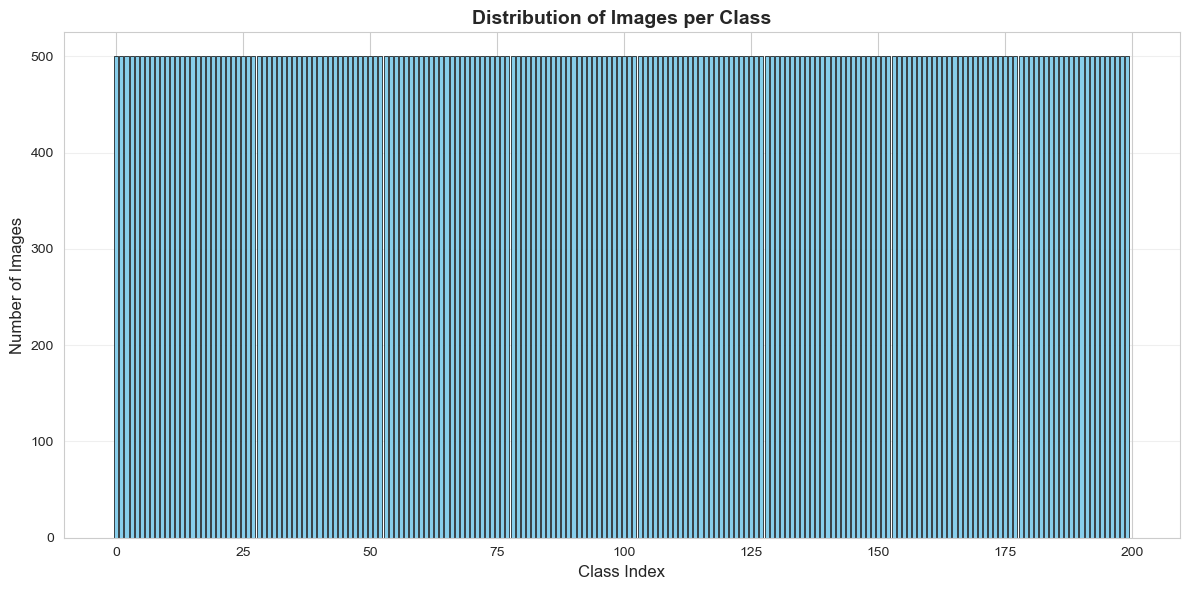

Min images per class: 500
Max images per class: 500
Mean images per class: 500.0
Std images per class: 0.0


In [52]:
# Class distribution histogram
plt.figure(figsize=(12, 6))
class_ids = list(train_counts.keys())
counts = list(train_counts.values())
plt.bar(range(len(class_ids)), counts, color='skyblue', edgecolor='black', linewidth=0.5)
plt.xlabel('Class Index', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Images per Class', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"Min images per class: {min(counts)}")
print(f"Max images per class: {max(counts)}")
print(f"Mean images per class: {np.mean(counts):.1f}")
print(f"Std images per class: {np.std(counts):.1f}")

## 3. Sample Images Visualization

Let's look at sample images from random classes to understand what we're working with.

In [53]:
def load_class_names(class_names_file="../data/class_mappings/class_names.txt"):
    """Load human-readable class names"""
    with open(class_names_file, 'r') as f:
        class_names = [line.strip() for line in f]
    return class_names

class_names = load_class_names()
print(f"Loaded {len(class_names)} class names")
print(f"First 5 classes: {class_names[:5]}")

Loaded 200 class names
First 5 classes: ['n01443537\tgoldfish', 'n01629819\tEuropean fire salamander', 'n01641577\tbullfrog', 'n01644900\ttailed frog', 'n01698640\tAmerican alligator']


/var/folders/8j/jz27y6g50kj22b3f9kkxc_qc0000gp/T/ipykernel_67841/1604798065.py:48: UserWarning: Glyph 9 (	) missing from font(s) Arial.
  plt.tight_layout()


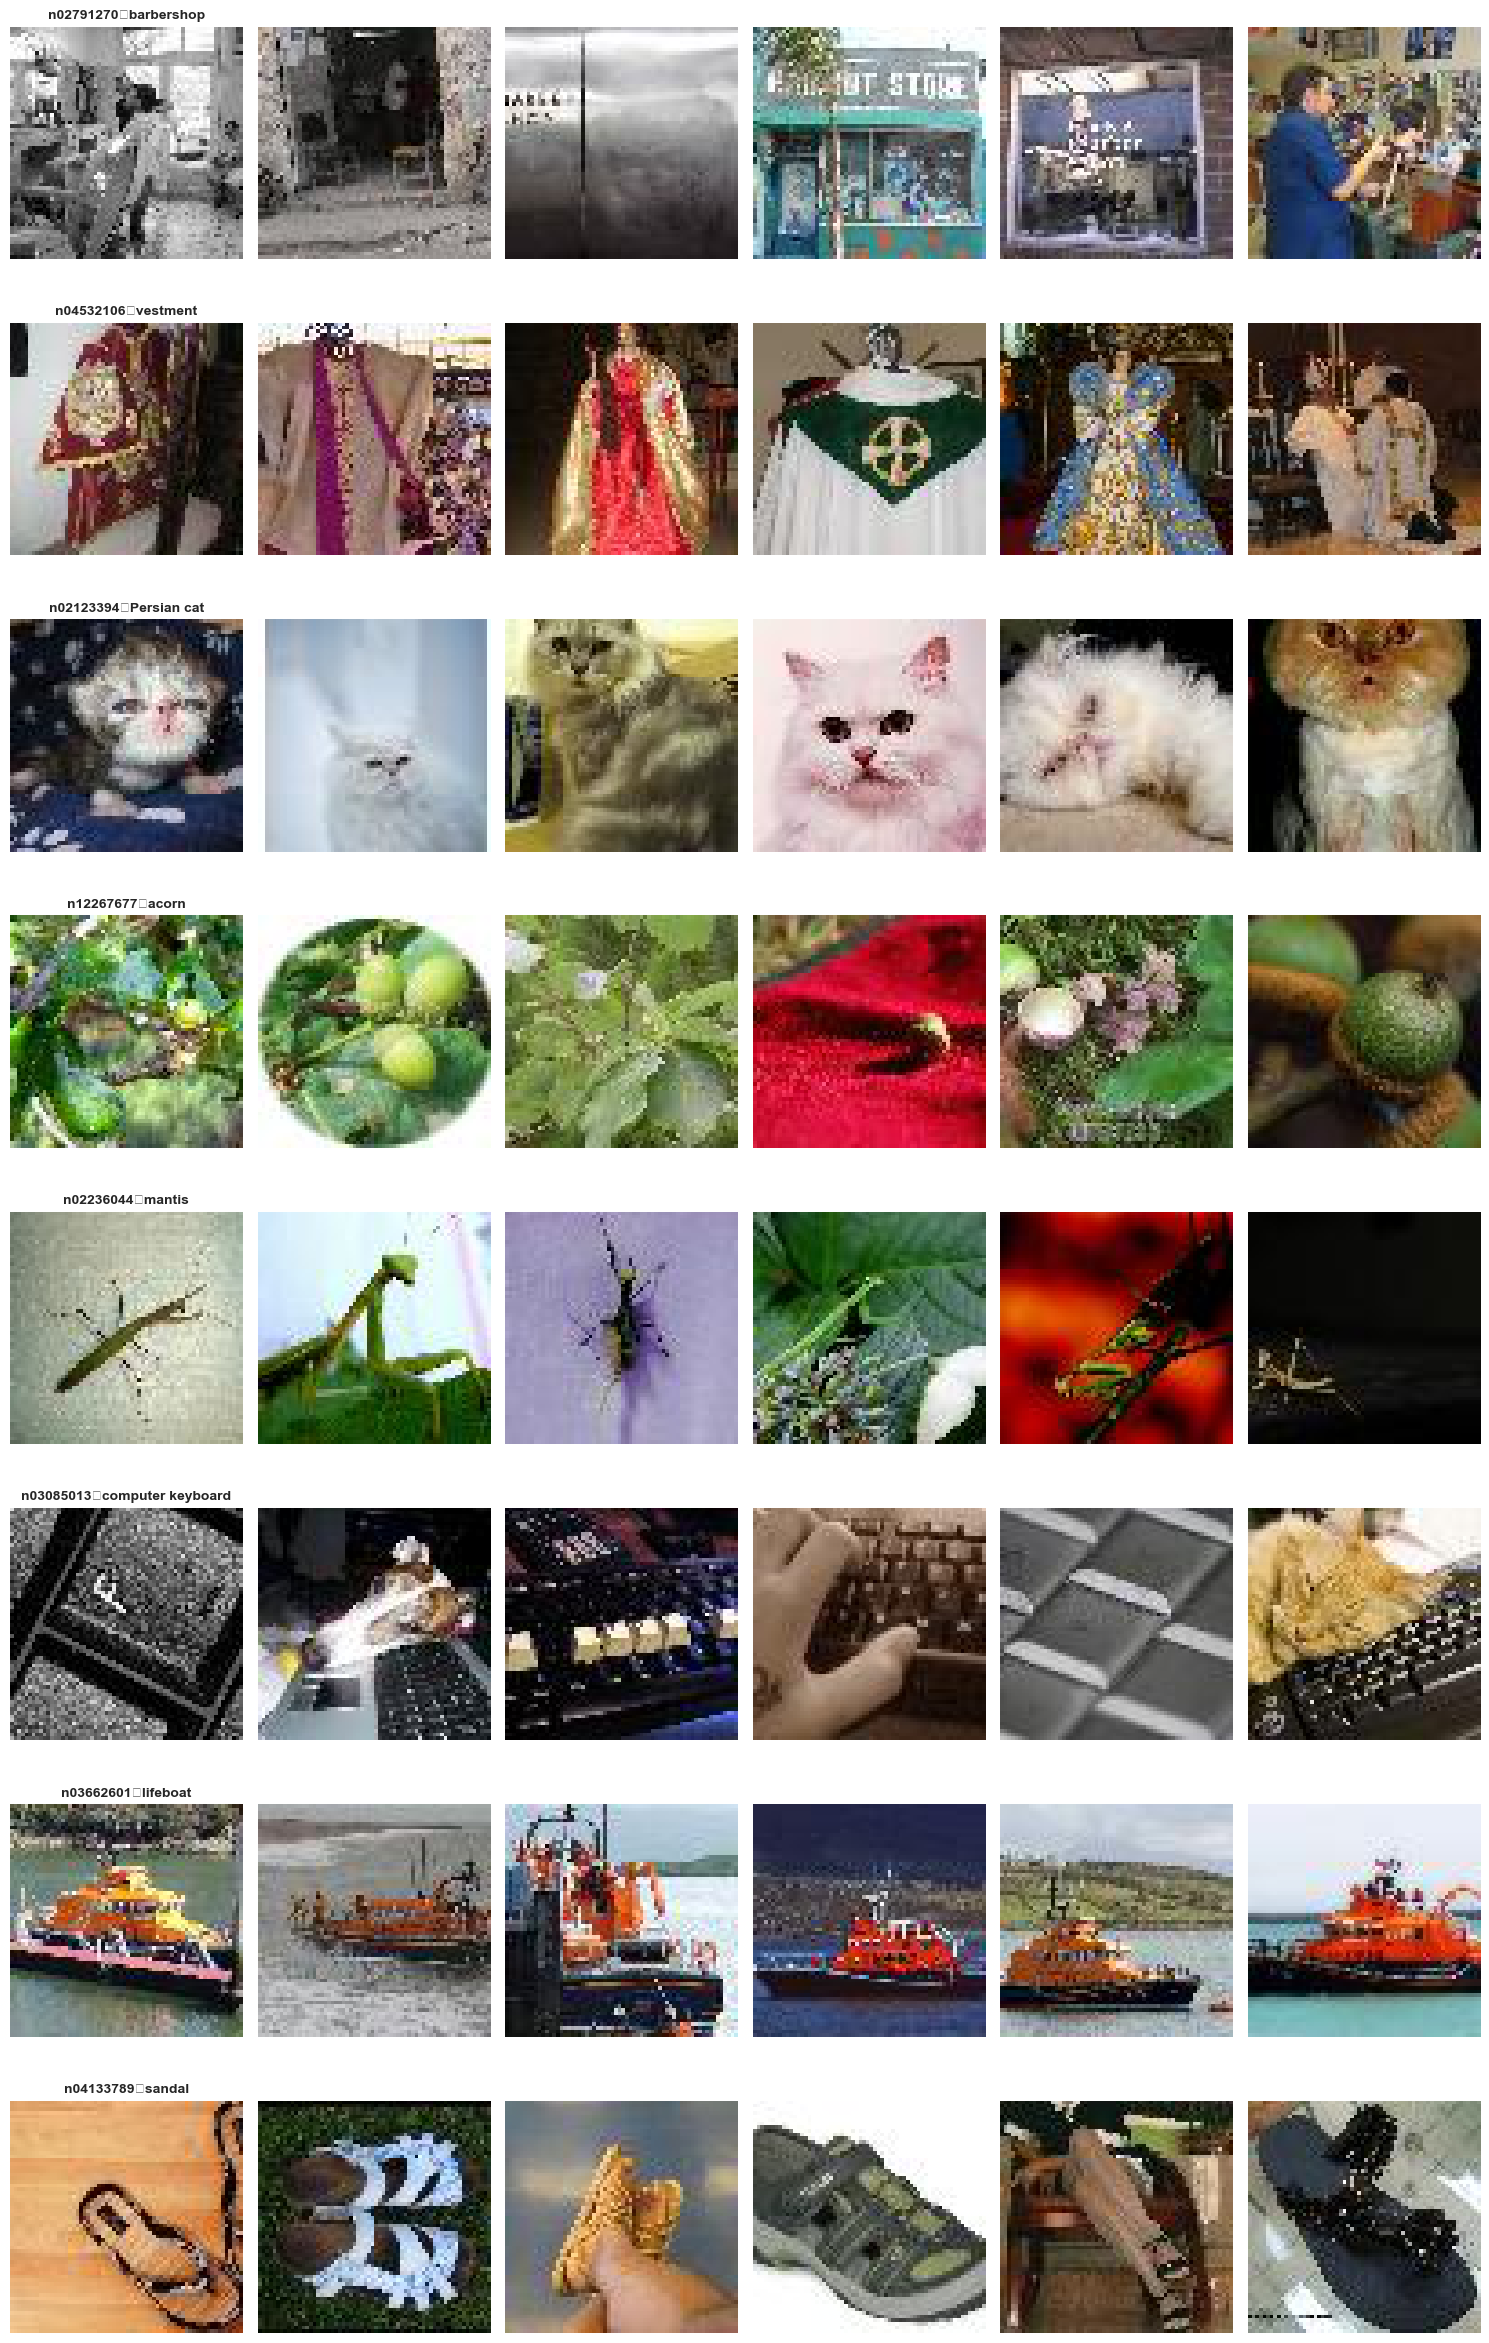

In [54]:
def visualize_sample_images(
    data_dir="../data/raw/tiny-imagenet-200",
    num_classes=10,
    num_samples_per_class=5
):
    """Visualize sample images from random classes"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    
    # Get random classes
    class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
    random_classes = random.sample(class_dirs, min(num_classes, len(class_dirs)))
    
    # Create figure
    fig, axes = plt.subplots(num_classes, num_samples_per_class, figsize=(15, 3*num_classes))
    
    for i, class_dir in enumerate(random_classes):
        images_dir = class_dir / "images"
        image_files = list(images_dir.glob("*.JPEG"))
        random_images = random.sample(image_files, min(num_samples_per_class, len(image_files)))
        
        # Get class name
        class_id = class_dir.name
        try:
            # Parse class index from WordNet ID (assuming format matches)
            class_name = class_id  # Default to ID
            for idx, name in enumerate(class_names):
                if class_id in name:
                    class_name = name.split(',')[0]  # Get first name
                    break
        except:
            class_name = class_id
        
        for j, img_file in enumerate(random_images):
            img = Image.open(img_file).convert('RGB')
            
            if num_classes == 1:
                ax = axes[j]
            else:
                ax = axes[i, j]
            
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(f'{class_name}', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

visualize_sample_images(num_classes=8, num_samples_per_class=6)

## 4. Image Statistics Analysis

Calculate mean and standard deviation for normalization.

In [55]:
def analyze_image_statistics(
    data_dir="../data/raw/tiny-imagenet-200", num_samples=1000
):
    """Analyze image statistics (mean, std, size distribution)"""
    data_path = Path(data_dir)
    train_dir = data_path / "train"

    # Collect sample images
    all_images = []
    for class_dir in train_dir.iterdir():
        if class_dir.is_dir():
            images_dir = class_dir / "images"
            all_images.extend(list(images_dir.glob("*.JPEG")))

    # Random sample
    sample_images = random.sample(all_images, min(num_samples, len(all_images)))

    # Calculate statistics
    means = []
    stds = []
    sizes = []

    transform = transforms.ToTensor()

    print(f"Analyzing {len(sample_images)} sample images...")

    for img_path in sample_images:
        try:
            img = Image.open(img_path).convert("RGB")
            sizes.append(img.size)

            img_tensor = transform(img)
            means.append(img_tensor.mean(dim=[1, 2]).numpy())
            stds.append(img_tensor.std(dim=[1, 2]).numpy())
        except Exception as e:
            continue

    # Calculate overall statistics
    mean_rgb = np.mean(means, axis=0)
    std_rgb = np.mean(stds, axis=0)

    print("\n" + "=" * 80)
    print("IMAGE STATISTICS")
    print("=" * 80)
    print(
        f"\nChannel-wise Mean (RGB):  [{mean_rgb[0]:.4f}, {mean_rgb[1]:.4f}, {mean_rgb[2]:.4f}]"
    )
    print(
        f"Channel-wise Std (RGB):   [{std_rgb[0]:.4f}, {std_rgb[1]:.4f}, {std_rgb[2]:.4f}]"
    )

    # Size distribution
    size_counter = Counter(sizes)
    print(f"\nImage Sizes:")
    for size, count in size_counter.most_common(5):
        print(f"  {size}: {count} images ({count/len(sizes)*100:.1f}%)")

    print("=" * 80 + "\n")

    return {
        "mean": mean_rgb.tolist(),
        "std": std_rgb.tolist(),
        "sizes": {str(k): v for k, v in size_counter.items()},
    }


stats = analyze_image_statistics(num_samples=2000)

Analyzing 2000 sample images...

IMAGE STATISTICS

Channel-wise Mean (RGB):  [0.4784, 0.4488, 0.4007]
Channel-wise Std (RGB):   [0.2289, 0.2254, 0.2260]

Image Sizes:
  (64, 64): 2000 images (100.0%)



## 5. Augmentation Visualization

See how different augmentation techniques transform images.

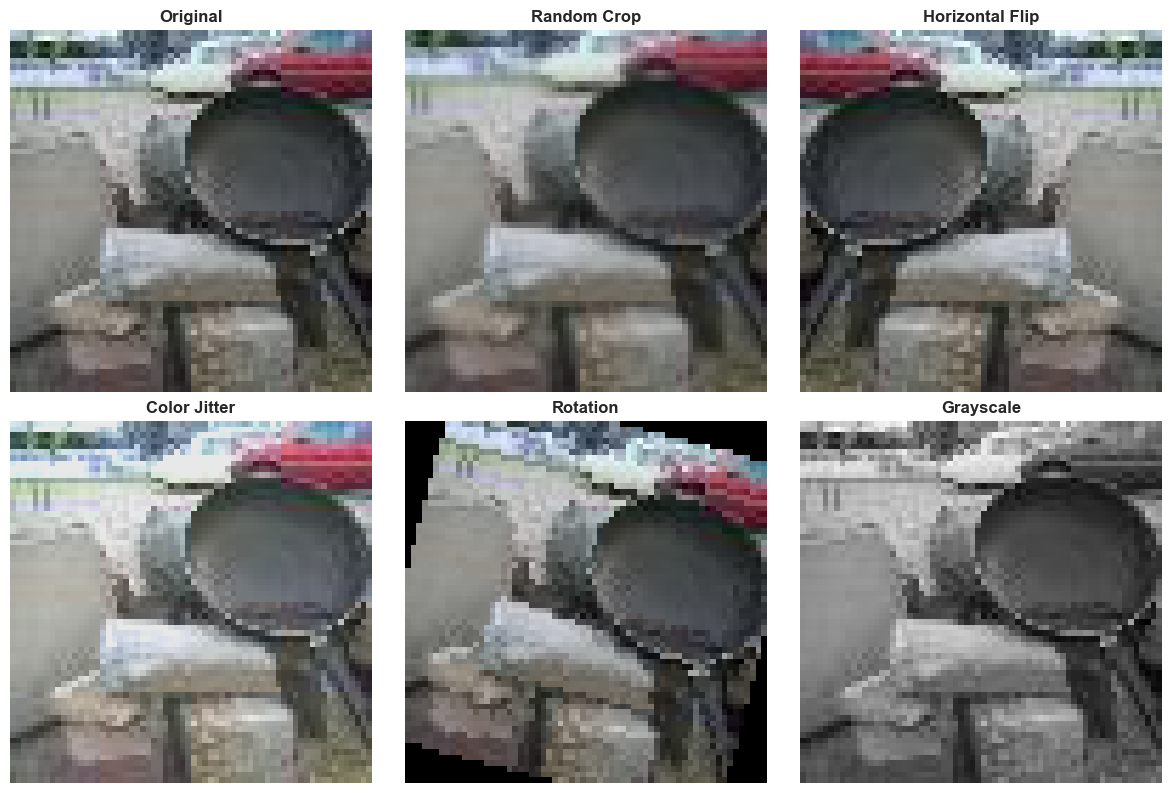

In [56]:
def visualize_augmentations(data_dir="../data/raw/tiny-imagenet-200"):
    """Visualize different augmentation techniques"""
    # Get a sample image
    data_path = Path(data_dir)
    train_dir = data_path / "train"
    class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
    sample_class = random.choice(class_dirs)
    images_dir = sample_class / "images"
    sample_image_path = random.choice(list(images_dir.glob("*.JPEG")))
    
    # Load image
    original_img = Image.open(sample_image_path).convert('RGB')
    
    # Define augmentations
    augmentations = {
        'Original': transforms.Compose([transforms.Resize((64, 64))]),
        'Random Crop': transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0))
        ]),
        'Horizontal Flip': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(p=1.0)
        ]),
        'Color Jitter': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
        ]),
        'Rotation': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomRotation(15)
        ]),
        'Grayscale': transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomGrayscale(p=1.0)
        ])
    }
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, (aug_name, aug_transform) in enumerate(augmentations.items()):
        aug_img = aug_transform(original_img)
        axes[idx].imshow(aug_img)
        axes[idx].set_title(aug_name, fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_augmentations()

## 6. Multiple Augmentation Examples

See multiple random augmentations applied to the same image.

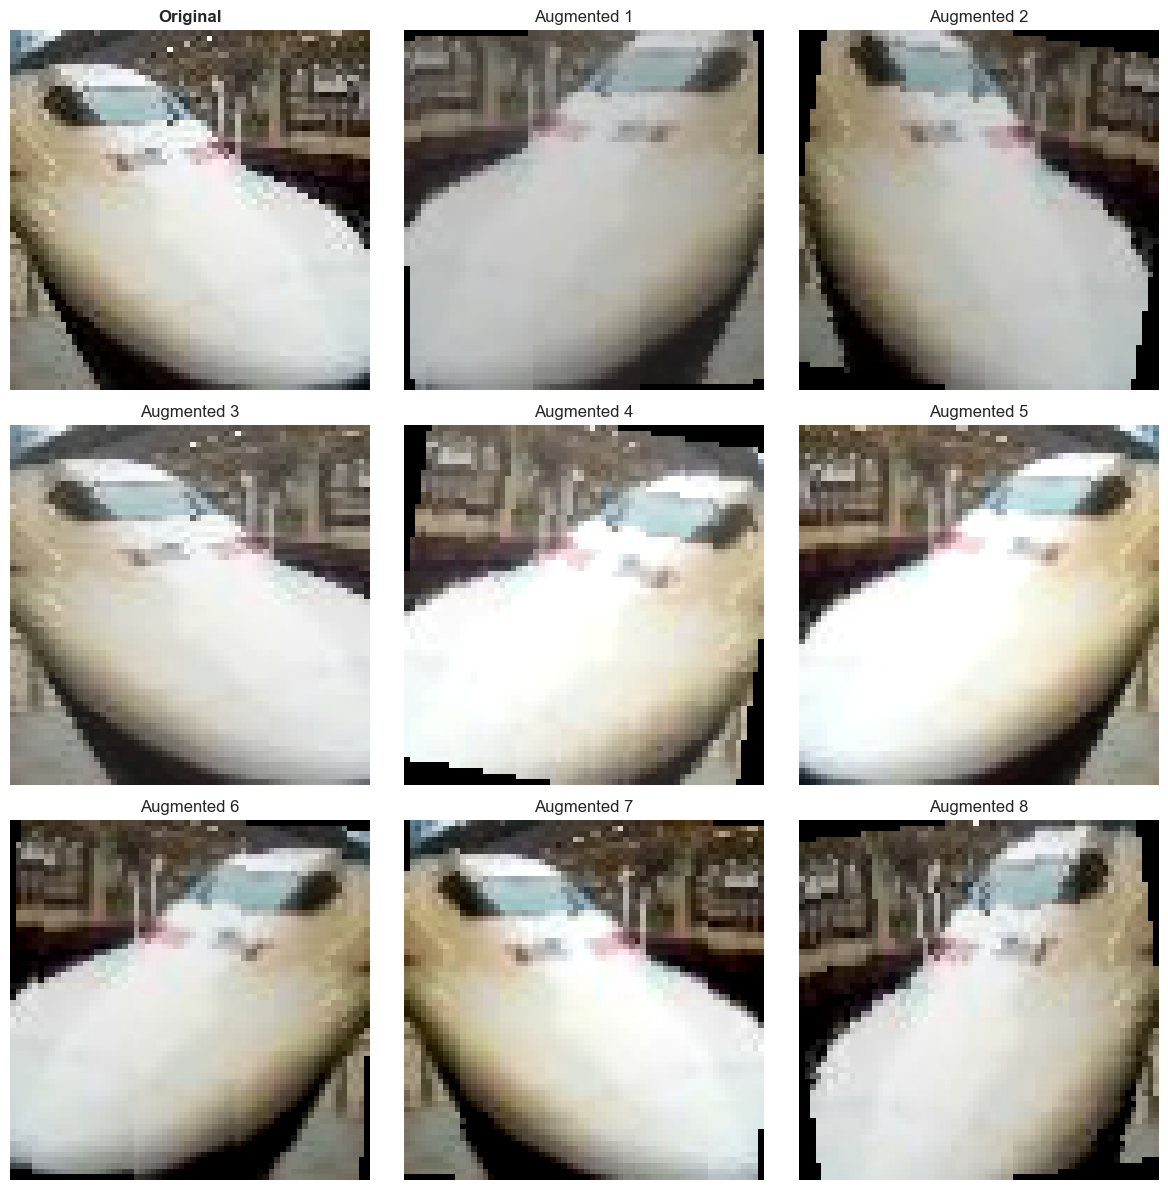

In [57]:
# Strong augmentation pipeline (like in training)
strong_aug = transforms.Compose([
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomRotation(10)
])

# Get a sample image
data_path = Path("../data/raw/tiny-imagenet-200")
train_dir = data_path / "train"
class_dirs = [d for d in train_dir.iterdir() if d.is_dir()]
sample_class = random.choice(class_dirs)
images_dir = sample_class / "images"
sample_image_path = random.choice(list(images_dir.glob("*.JPEG")))
original_img = Image.open(sample_image_path).convert('RGB')

# Show original and 8 augmented versions
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()

# Original
axes[0].imshow(transforms.Resize((64, 64))(original_img))
axes[0].set_title('Original', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Augmented versions
for i in range(1, 9):
    aug_img = strong_aug(original_img)
    axes[i].imshow(aug_img)
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 7. Summary Report

Generate a summary of findings.

In [58]:
report = {
    'num_classes': len(train_counts),
    'total_train_images': sum(train_counts.values()),
    'images_per_class': list(train_counts.values())[0] if train_counts else 0,
    'image_statistics': stats
}

print("\n" + "="*80)
print("DATA EXPLORATION SUMMARY")
print("="*80)
print(json.dumps(report, indent=2))
print("="*80 + "\n")

# Optionally save
# with open('../results/data_exploration_report.json', 'w') as f:
#     json.dump(report, f, indent=4)


DATA EXPLORATION SUMMARY
{
  "num_classes": 200,
  "total_train_images": 100000,
  "images_per_class": 500,
  "image_statistics": {
    "mean": [
      0.47836562991142273,
      0.44884002208709717,
      0.40066489577293396
    ],
    "std": [
      0.22888419032096863,
      0.22541497647762299,
      0.22599278390407562
    ],
    "sizes": {
      "(64, 64)": 2000
    }
  }
}

